In [15]:
import tf_freq_id
import tracetools as tt
import matplotlib.pyplot as plt 
import numpy as np
import control as ctrl
from utils import *

ast = tt.parse_autotune_file(r'AST files\AST_AX7.xml')
s = ctrl.tf('s')

# Plant

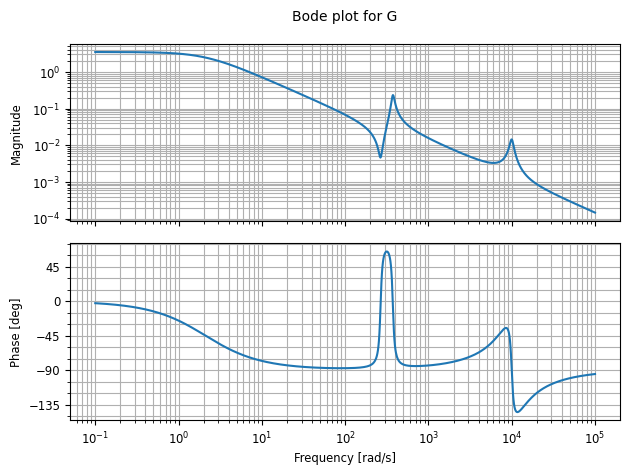

In [16]:

Gf = tf_from_txt(r'tf_txt\Gf.txt')
Gf.name = 'G'
ctrl.bode(Gf)

In [17]:
Gf

TransferFunction(array([1.44707431e+01, 1.45028212e+05, 1.45130879e+09, 4.23448419e+10,
       1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649869e+09,
       1.39902598e+13, 2.93312041e+13]))

# Model error (Multiplicatibly uncertainty)

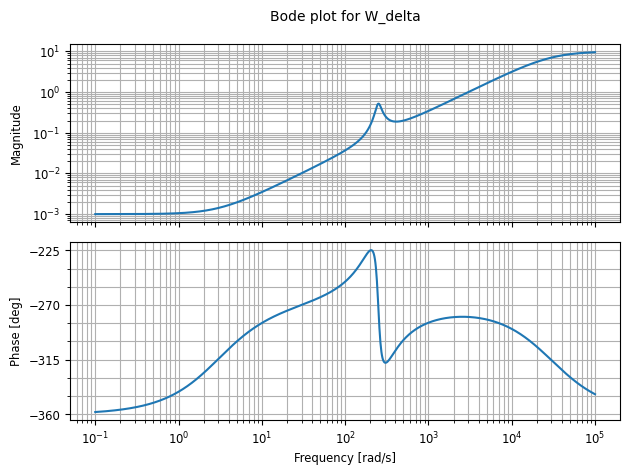

In [18]:
W_delta = tf_from_txt(r'tf_txt\W_delta.txt')
W_delta.name = 'W_delta'
ctrl.bode(W_delta)

# Controller from AST

In [19]:
print(ast.speed_ctrl_params)

speed_ctrl = ast.speed_ctrl_params

C = speed_ctrl.Kp*(1 + 1/(s*speed_ctrl.Ti))

assert len(speed_ctrl.act_value_filters) == 0

F = 1 

print("Torque setpoint filters: ")

for filt in speed_ctrl.current_setp_filters:
    print(filt)
    if isinstance(filt,tt.tracetypes.PT2):
        pt2i = tt.sinu_tf.PT2(filt.freq,filt.damping)
        F *= pt2i
    elif isinstance(filt,tt.tracetypes.SecondOrdFilter):
        pt2i = tt.sinu_tf.PT2(filt.den_f,filt.den_d) / tt.sinu_tf.PT2(filt.num_f,filt.num_d)
        F *= pt2i
    else:
        raise Exception('Only PT2 filter supported for now..')
    

C_ast = C*F
C_ast.name = 'C_ast'
C_ast

SpeedCtrl(Kp=22.242147839669272, Ti=0.035, Ts=0.00025, ref_mdl_active=True, ref_mdl_freq=37.567485311159444, ref_mdl_d=0.7071, ref_mdl_delay=0.0, act_value_filters=[], current_setp_filters=[PT2(freq=2000.0, damping=0.7071), SecondOrdFilter(num_f=1565.5577299412917, num_d=0.10216246366713959, den_f=1565.5577299412917, den_d=0.25)])
Torque setpoint filters: 
PT2(freq=2000.0, damping=0.7071)
SecondOrdFilter(num_f=1565.5577299412917, num_d=0.10216246366713959, den_f=1565.5577299412917, den_d=0.25)


TransferFunction(array([1.18949441e+16, 2.42472757e+19, 1.15164330e+24, 3.28845779e+25]), array([3.38661599e+06, 7.68413211e+10, 1.15849295e+15, 8.45380258e+18,
       5.17468113e+22, 0.00000000e+00]))

# Import Hinf controller

In [20]:


lines = []
with open(r'tf_txt/C_hinf.txt','r') as f:
    lines = f.readlines()
lines

lines = [x.strip().replace('[','').replace(']','') for x in lines]
    

num = [float(x) for x in lines[0].split(',')]
den = [float(x) for x in lines[1].split(',')]

num = np.array(num)
den = np.array(den)

num =  np.flip(num)
den = np.flip(den)

C_hinf = ctrl.tf(num,den)
C_hinf.name = 'C_Hinf'

C_hinf

TransferFunction(array([5.70445642e-02, 1.15985156e+05, 6.08480118e+10, 1.91900232e+15,
       1.17705965e+19, 1.89165296e+23, 3.86543105e+26, 6.53860887e+28,
       7.70639955e+31, 4.58832300e+33, 3.24705856e+36, 6.79141031e+36]), array([1.00000000e+00, 3.70955630e+04, 3.35007426e+08, 4.31268139e+12,
       2.10913690e+16, 5.14818591e+19, 7.15978534e+22, 4.73054658e+25,
       1.20054717e+28, 5.78848399e+30, 4.99488922e+32, 1.86552230e+35,
       2.56415033e+34]))

# Import IMC Controller

In [21]:

C_imc = tf_from_txt(r'tf_txt\C_imc.txt')
C_imc.name = 'C_IMC'
C_imc

TransferFunction(array([6.82038533e+03, 7.04452407e+06, 6.83216844e+11, 2.33700414e+13,
       9.54189628e+16, 2.00050114e+17]), array([1.00000000e+00, 1.04663888e+04, 1.04744683e+08, 4.74783479e+10,
       8.39472684e+12, 3.15167380e+15, 0.00000000e+00]))

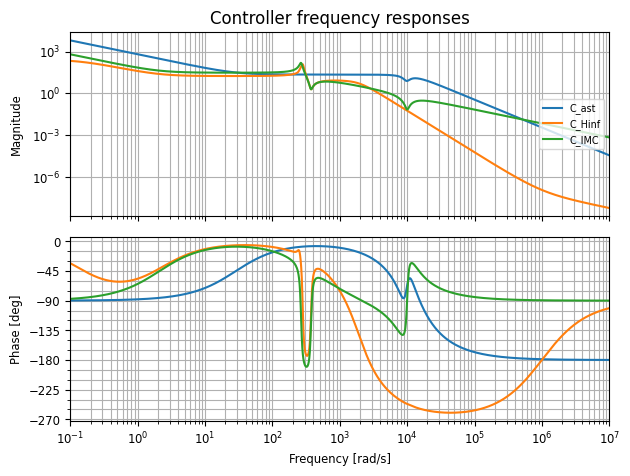

In [22]:

omega_lim = (0.1,1e7)

ctrl.bode(C_ast,omega_limits=omega_lim)
ctrl.bode(C_hinf,omega_limits=omega_lim)
ctrl.bode(C_imc,omega_limits=omega_lim)

plt.subplot(2,1,1)
plt.title('Controller frequency responses')

save_fig('controllers')



# Open loop and stability margins

0 states have been removed from the model
6 states have been removed from the model
9 states have been removed from the model


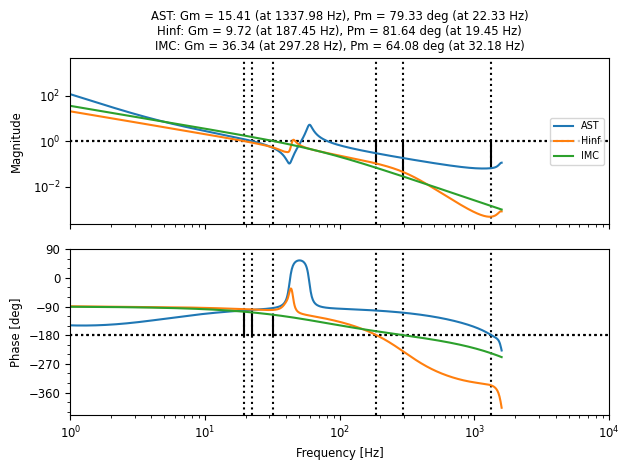

In [23]:

L = Gf*C_ast
L = ctrl.minreal(L)
L.name = 'AST'

Lh = C_hinf*Gf
Lh = ctrl.minreal(Lh)
Lh.name = 'Hinf'

L_imc = Gf*C_imc
L_imc = ctrl.minreal(L_imc)
L_imc.name = 'IMC'



delay = tt.sinu_tf.pade(125*1e-6,2)

Ld = delay*L
Lhd = delay*Lh
L_imcd = delay*L_imc

Ld.name = 'AST'
Lhd.name = 'Hinf'
L_imcd.name = 'IMC'

f_limits = (1,1e4)

ctrl.bode(Ld,display_margins=True,Hz=True,omega_limits=f_limits)   

#plt.figure()

ctrl.bode(Lhd,display_margins=True,Hz=True,omega_limits=f_limits)

#plt.figure()

ctrl.bode(L_imcd,display_margins=True,Hz=True,omega_limits=f_limits)

save_fig('open_loop_margins')


# Sensitivity

0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model
S_peak_ast: 1.1176417612581857
S_peak_hinf: 1.1661976307805013
S_peak_imc: 1.272081361745116


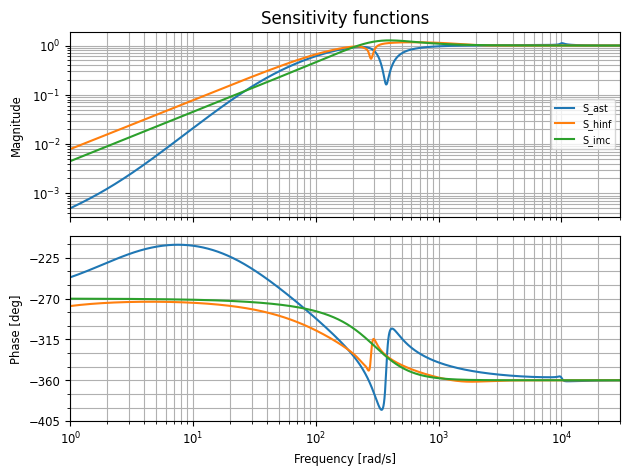

In [24]:

S_ast = 1/(1+L)
S_ast = ctrl.minreal(S_ast)
S_ast.name = 'S_ast'

S_hinf = 1/(1+Lh)
S_hinf = ctrl.minreal(S_hinf)
S_hinf.name = 'S_hinf'

S_imc = 1/(1+L_imc)
S_imc = ctrl.minreal(S_imc)
S_imc.name = 'S_imc'


omega_limits = [1,3*1e4]

ctrl.bode(S_ast,omega_limits=omega_limits)
ctrl.bode(S_hinf,omega_limits=omega_limits)
ctrl.bode(S_imc,omega_limits=omega_limits)


def peak_norm(G):

    Y = ctrl.frequency_response(G).response[0][0]
    return np.max(np.abs(Y))


S_peak_ast = peak_norm(S_ast)
S_peak_hinf = peak_norm(S_hinf)
S_peak_imc = peak_norm(S_imc)

print(f'S_peak_ast: {S_peak_ast}')
print(f'S_peak_hinf: {S_peak_hinf}')
print(f'S_peak_imc: {S_peak_imc}')

plt.subplot(2,1,1)
plt.title('Sensitivity functions')

save_fig('sensitivity_functions')


# Robust stability

Condition for robust stability

$$
|T(s)W_\Delta(s)| < 1
$$


10 states have been removed from the model
13 states have been removed from the model
2 states have been removed from the model
T_rob_ast_peak: 0.39592779210309004
T_rob_hinf_peak: 0.2076816061395234
T_rob_imc_peak: 0.4403516889581081


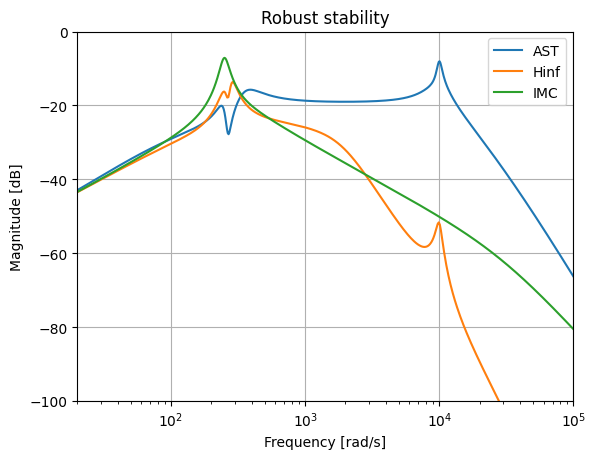

In [25]:

T_rob_ast = L*S_ast*W_delta
T_rob_ast = ctrl.minreal(T_rob_ast)
T_rob_ast.name = 'T_rob_ast'

T_rob_hinf = Lh*S_hinf*W_delta
T_rob_hinf = ctrl.minreal(T_rob_hinf)
T_rob_hinf.name = 'T_rob_hinf'

T_rob_imc = L_imc*S_imc*W_delta
T_rob_imc = ctrl.minreal(T_rob_imc)
T_rob_imc.name = 'T_rob_imc'

#ctrl.bode(T_rob_ast)
#ctrl.bode(T_rob_hinf)
#ctrl.bode(T_rob_imc)

bodemag(T_rob_ast,label='AST')
bodemag(T_rob_hinf,label='Hinf')
bodemag(T_rob_imc,label='IMC')
plt.grid('on')
plt.xlim(20,1e5)
plt.ylim(-100,0)
plt.legend()
plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [rad/s]')
plt.title('Robust stability')

T_rob_ast_peak = peak_norm(T_rob_ast)
T_rob_hinf_peak = peak_norm(T_rob_hinf)
T_rob_imc_peak = peak_norm(T_rob_imc)

print(f'T_rob_ast_peak: {T_rob_ast_peak}')
print(f'T_rob_hinf_peak: {T_rob_hinf_peak}')
print(f'T_rob_imc_peak: {T_rob_imc_peak}')


save_fig('robust_stability')


# Closed loop

0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model


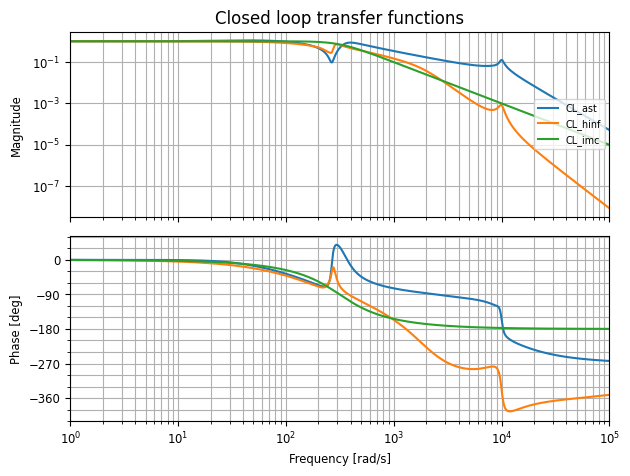

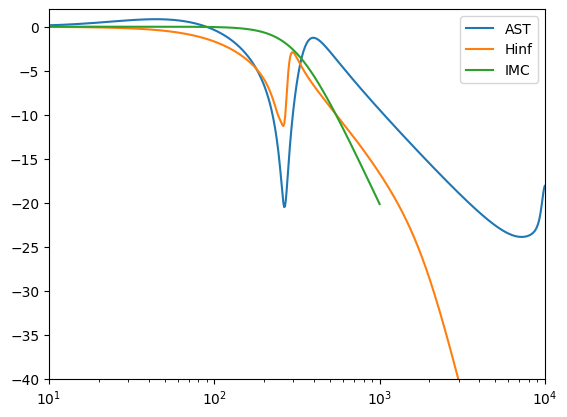

In [26]:

CL_ast = ctrl.feedback(L)
CL_ast = ctrl.minreal(CL_ast)
CL_ast.name = 'CL_ast'

CL_hinf = ctrl.feedback(Lh)
CL_hinf = ctrl.minreal(CL_hinf)
CL_hinf.name = 'CL_hinf'

CL_imc = ctrl.feedback(L_imc)
CL_imc = ctrl.minreal(CL_imc)
CL_imc.name = 'CL_imc'

omega_lim = (1,1e5)

ctrl.bode(CL_ast,omega_limits=omega_lim)
ctrl.bode(CL_hinf,omega_limits=omega_lim)
ctrl.bode(CL_imc,omega_limits=omega_lim)

plt.subplot(2,1,1)
plt.title('Closed loop transfer functions')

save_fig('closed_loop')

plt.figure()
plot_mag(CL_ast)
plot_mag(CL_hinf,)
plot_mag(CL_imc)
plt.xlim([10,1e4])
plt.ylim([-40,2])
plt.legend(['AST','Hinf','IMC'])


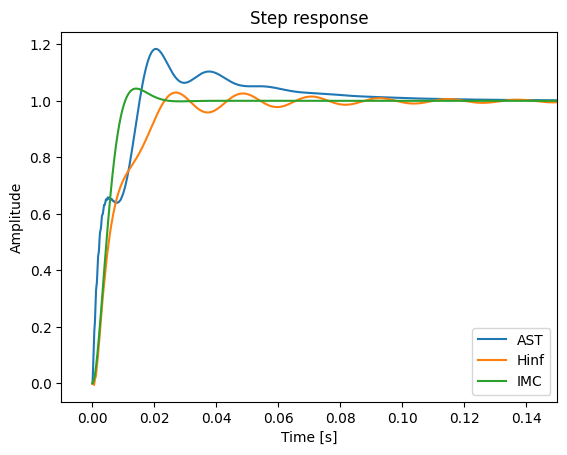

In [27]:

t = np.linspace(0,0.4,100000)
t0, y0 = ctrl.step_response(CL_ast,T=t)
t1, y1 = ctrl.step_response(CL_hinf,T=t)
t2, y2 = ctrl.step_response(CL_imc,T=t)

plt.plot(t0,y0)
plt.plot(t1,y1)
plt.plot(t2,y2)

plt.legend(['AST','Hinf','IMC'],loc='lower right')
plt.xlim([-0.01,0.15])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Step response')

save_fig('step_response')

# IMC with zeros in ref mdl

5 states have been removed from the model
0 states have been removed from the model
5 states have been removed from the model
0 states have been removed from the model


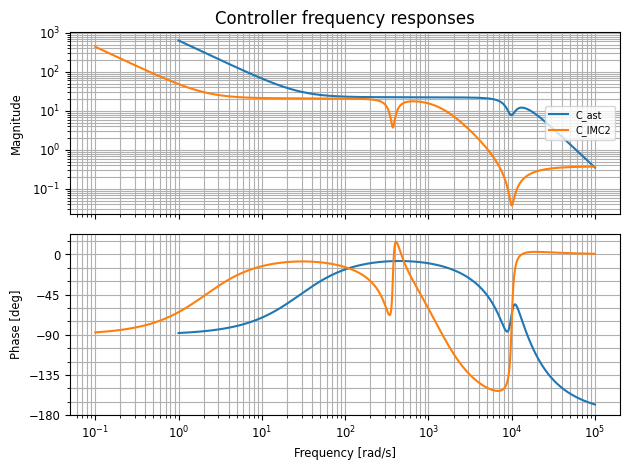

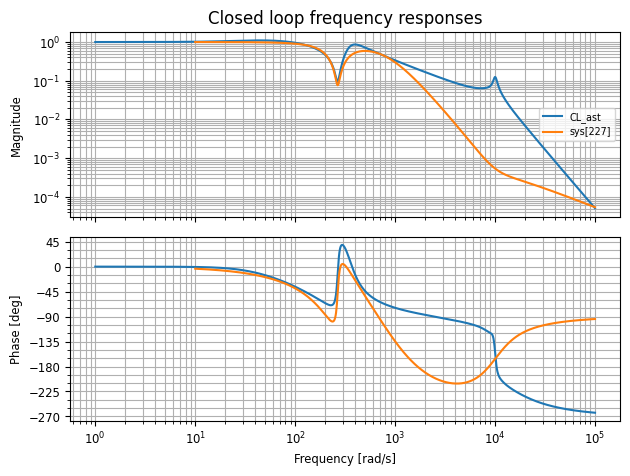

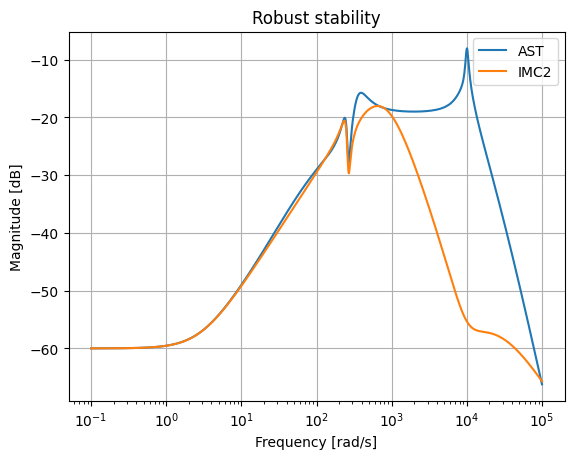

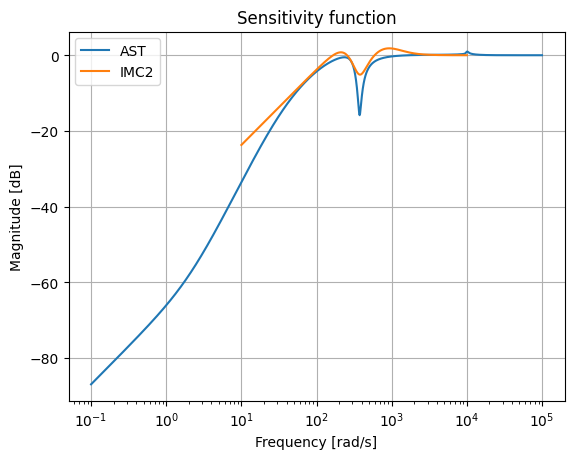

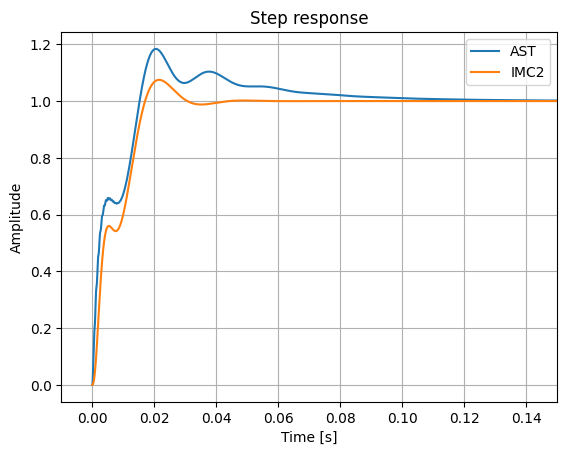

In [28]:
C_imc2 = tf_from_txt(r'tf_txt\C_imc2.txt')
C_imc2.name = 'C_IMC2'

L_imc2 = Gf*C_imc2
L_imc2 = ctrl.minreal(L_imc2)
L_imc2.name = 'IMC2'


S_imc2 = 1/(1+L_imc2)
S_imc2 = ctrl.minreal(S_imc2)
S_imc2.name = 'S_imc2'

T_rob_imc2 = L_imc2*S_imc2*W_delta
T_rob_imc2 = ctrl.minreal(T_rob_imc2)
T_rob_imc2.name = 'T_rob_imc2'

CL_imc2 = ctrl.feedback(L_imc2)
CL_imc2 = ctrl.minreal(CL_imc2)


ctrl.bode(C_ast)
ctrl.bode(C_imc2)

plt.subplot(2,1,1)
plt.title('Controller frequency responses')

save_fig('C_imc2_vs_ast')

plt.figure()

ctrl.bode(CL_ast)
ctrl.bode(CL_imc2)

plt.subplot(2,1,1)
plt.title('Closed loop frequency responses')

save_fig('CL_imc2_vs_ast')

plt.figure()

bodemag(T_rob_ast,label='AST')
bodemag(T_rob_imc2,label='IMC2')
plt.legend()
plt.grid('on')
plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [rad/s]')
plt.title('Robust stability')

save_fig('robust_stability_imc2_vs_ast')


plt.figure()

bodemag(S_ast,label='AST')
bodemag(S_imc2,label='IMC2')
plt.legend()
plt.grid('on')
plt.ylabel('Magnitude [dB]')
plt.xlabel('Frequency [rad/s]')
plt.title('Sensitivity function')

save_fig('sensitivity_imc2_vs_ast')

plt.figure()

t22,y22 = ctrl.step_response(CL_imc2,T=t)

plt.plot(t0,y0,label='AST')
plt.plot(t22,y22,label='IMC2')
plt.legend()
plt.xlim([-0.01,0.15])
plt.grid('on')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Step response')



save_fig('step_response_imc2_vs_ast')

